# 3.0-Normalization and Embedding 

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-09"

## Introduction

Normalize data and create embeddings for the each time point fraction

In [2]:
timepoint <- "T7"

## Libraries

In [3]:
suppressMessages(suppressWarnings({
library(Seurat)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggplot2)
library(harmony)
library(scater) 
library(scran)
}))

## Parameters

In [4]:
#here::dr_here(show_reason = TRUE)
source(here::here("SCGRES_119_120/sc_analysis/misc/paths.R"))

"{clust}/{plt_dir}" %>%
  glue::glue() %>%
  here::here() %>%
  dir.create(path = .,
           showWarnings = FALSE,
           recursive = TRUE)

"{clust}/{robj_dir}" %>%
  glue::glue() %>%
  here::here() %>%
  dir.create(path = .,
           showWarnings = FALSE,
           recursive = TRUE)

set.seed(0)

## Load data

In [5]:
seurat_obj <- readRDS(here::here(glue::glue("{qc}/{robj_dir}/clean_combined_object_{timepoint}.rds")))

In [6]:
head(seurat_obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,sample_org,timepoint,replicate,sample_id,pct_mt,percent.ribo,doublet_score,doublet_pred
,<chr>,<dbl>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
T7_1_AAACCTGAGAGCCTAG-1,SCGRES_119_120,1732,1136,OS0107_1,T7,1,T7_1,1.6166282,13.914550,0.05583456,FALSE
T7_1_AAACCTGAGAGTACAT-1,SCGRES_119_120,2675,1503,OS0107_1,T7,1,T7_1,1.9813084,14.392523,0.12286159,FALSE
T7_1_AAACCTGAGAGTACCG-1,SCGRES_119_120,4312,1887,OS0107_1,T7,1,T7_1,0.9276438,13.682746,0.03218814,FALSE
T7_1_AAACCTGAGCACGCCT-1,SCGRES_119_120,2160,1282,OS0107_1,T7,1,T7_1,2.3611111,15.324074,0.04439583,FALSE
T7_1_AAACCTGAGGCAATTA-1,SCGRES_119_120,4541,2194,OS0107_1,T7,1,T7_1,1.8718344,12.376129,0.02912621,FALSE
T7_1_AAACCTGAGGCGCTCT-1,SCGRES_119_120,1708,1073,OS0107_1,T7,1,T7_1,7.4355972,1.932084,0.02633915,FALSE


## Normalization and linear dimensional reduction

In [7]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [8]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 29656 30389 
metadata(0):
assays(2): counts logcounts
rownames(29656): AL627309.1 AL627309.5 ... AC136612.1 AC007325.2
rowData names(0):
colnames(30389): T7_1_AAACCTGAGAGCCTAG-1 T7_1_AAACCTGAGAGTACAT-1 ...
  T7_2_TTTGTCATCCATGAAC-1 T7_2_TTTGTCATCCCTAACC-1
colData names(12): orig.ident nCount_RNA ... doublet_pred ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


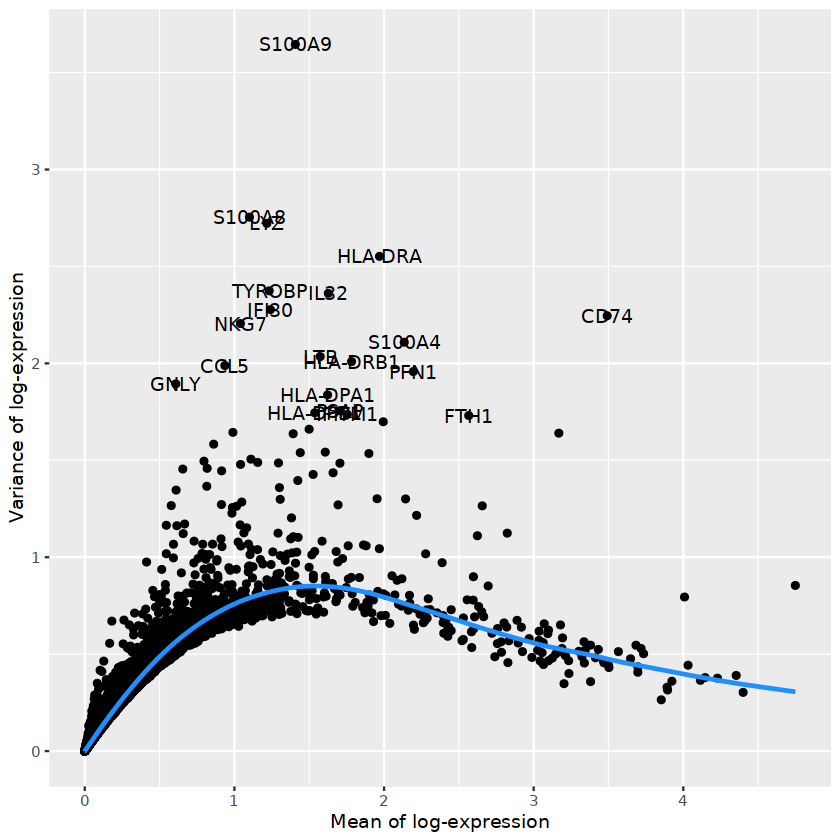

In [9]:
gene_var <- modelGeneVar(sce)

tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")+
  geom_text(data=tops, aes(mean,total,label=rownames(tops)))

In [10]:
gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

,mean,total,tech,bio,p.value,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S100A9,1.4072250,3.644964,0.8456430,2.7993210,2.309736e-125,3.379952e-121
S100A8,1.1005814,2.754224,0.7899255,1.9642987,1.040445e-71,1.450033e-68
LYZ,1.2170008,2.722009,0.8173694,1.9046398,3.135410e-63,3.398668e-60
HLA-DRA,1.9697312,2.552010,0.8009678,1.7510424,6.576813e-56,5.202259e-53
TYROBP,1.2326330,2.374137,0.8204906,1.5536463,1.835813e-42,7.901285e-40
IL32,1.6275931,2.361086,0.8491327,1.5119537,8.790735e-38,3.099740e-35
IFI30,1.2406979,2.277176,0.8220186,1.4551576,2.285739e-37,7.963896e-35
CD74,3.4913679,2.245437,0.4752270,1.7702104,4.000103e-158,1.170710e-153
NKG7,1.0400708,2.205487,0.7723811,1.4331064,7.495608e-41,2.964513e-38


In [11]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.1)
length(hvgs)

[1] 1457

In [12]:
hvgs

[1] "S100A9"       "S100A8"       "LYZ"          "CD74"        
   [5] "HLA-DRA"      "TYROBP"       "IL32"         "IFI30"       
   [9] "NKG7"         "S100A4"       "GNLY"         "CCL5"        
  [13] "PFN1"         "LTB"          "HLA-DRB1"     "FTL"         
  [17] "FTH1"         "HLA-DPA1"     "PSAP"         "S100A6"      
  [21] "IFITM1"       "HLA-DPB1"     "FCER1G"       "CST3"        
  [25] "CD79A"        "FCN1"         "S100A11"      "HLA-DQB1"    
  [29] "BANK1"        "GZMA"         "IGHM"         "VIM"         
  [33] "AIF1"         "LGALS1"       "HLA-DQA1"     "CD69"        
  [37] "SAT1"         "HIST1H1E"     "LST1"         "CTSS"        
  [41] "MS4A1"        "NEAT1"        "MTRNR2L12"    "VCAN"        
  [45] "SRGN"         "S100A10"      "AFF3"         "GZMB"        
  [49] "MALAT1"       "IFITM3"       "BACH2"        "ZFP36"       
  [53] "FOS"          "ZEB2"         "SERPINA1"     "CST7"        
  [57] "CD3E"         "NAMPT"        "LYN"          "PRF1"        
  [61] "CRIP1"        "CD83"         "JUN"          "IGKV3-20"    
  [65] "GAPDH"        "ANXA1"        "SPI1"         "IL7R"        
  [69] "RALGPS2"      "AHNAK"        "CD7"          "ACTB"        
  [73] "JCHAIN"       "HLA-DRB5"     "IL1B"         "IGHV3-23"    
  [77] "AL138963.4"   "CD3D"         "TUBA1B"       "TCL1A"       
  [81] "NFKBIA"       "HIST1H1C"     "CXCR4"        "PLXDC2"      
  [85] "CYBB"         "HIST1H1B"     "NCF1"         "CTSW"        
  [89] "GRN"          "HIST1H1D"     "PRKCH"        "IGLV2-14"    
  [93] "CD247"        "FCGR3A"       "PLAUR"        "SLC8A1"      
  [97] "GZMK"         "CD68"         "SKAP1"        "ARHGAP26"    
 [101] "MNDA"         "IGHV3-30"     "CD79B"        "GZMH"        
 [105] "JUNB"         "ANXA2"        "IGKV4-1"      "IGKC"        
 [109] "FCRL1"        "MS4A6A"       "PCED1B-AS1"   "CD52"        
 [113] "DUSP6"        "HMGB2"        "AOAH"         "LTA4H"       
 [117] "STMN1"        "S100A12"      "TCF7"         "IGKV3-11"    
 [121] "BCL2"         "MT2A"         "SH3BGRL3"     "CD14"        
 [125] "TYMP"         "FGFBP2"       "LEF1"         "WARS"        
 [129] "ACTG1"        "CAMK4"        "EBF1"         "CXCL8"       
 [133] "HIST1H4C"     "IGHV3-7"      "LGALS2"       "IGLV1-44"    
 [137] "NIBAN3"       "TRBV28"       "KIF5C"        "LGALS3"      
 [141] "RBM47"        "IGHV4-34"     "CD8B"         "FGL2"        
 [145] "IGHV5-51"     "THEMIS"       "NCF2"         "DMXL2"       
 [149] "CD8A"         "TRBV20-1"     "RRM2"         "KLRB1"       
 [153] "TEX14"        "HIST1H2AL"    "HIST1H3C"     "FAM13A"      
 [157] "SPON2"        "CD36"         "AC020916.1"   "IGKV3-15"    
 [161] "CCL4"         "IGHV1-2"      "NELL2"        "IGLV3-21"    
 [165] "TRBV7-9"      "TRBC1"        "G0S2"         "MEF2C"       
 [169] "IGLV1-51"     "LINC00926"    "TGFBR3"       "PAX5"        
 [173] "TRBV5-1"      "IGKV1-17"     "IGHV3-21"     "IGHV3-15"    
 [177] "MZB1"         "TMEM176B"     "TOX"          "IGLV1-47"    
 [181] "MS4A7"        "IGKV1-5"      "LILRB2"       "CLEC7A"      
 [185] "KLRK1"        "LRP1"         "HIST1H3B"     "HIST1H4F"    
 [189] "CCL3"         "IGHD"         "IGHV4-59"     "IL2RB"       
 [193] "IGLV2-23"     "TCF7L2"       "BLK"          "IGHV4-39"    
 [197] "EGR1"         "KLRD1"        "SOX5"         "IFI27"       
 [201] "HIST1H2AH"    "TCF4"         "CD22"         "VPREB3"      
 [205] "MKI67"        "C1QA"         "COL19A1"      "IGHA1"       
 [209] "CSF1R"        "IGLV2-8"      "IGHV3-33"     "IGLC1"       
 [213] "FCER2"        "IGLV2-11"     "APOBEC3A"     "HOPX"        
 [217] "TRBV27"       "RUBCNL"       "IGLV1-40"     "PLEKHG1"     
 [221] "IGKV1-9"      "IGHV3-53"     "CCDC200"      "HIST1H2AI"   
 [225] "IGHV4-61"     "GNG7"         "HBB"          "ANK3"        
 [229] "TRBV6-5"      "CFD"          "PPBP"         "IGLV3-25"    
 [233] "IGHG1"        "TRBV19"       "CLIC3"        "HIST1H2AG"   
 [237] "CD19"         "CCSER1"       "C1QB"       

In [13]:
# remove TCR genes
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]

# remove BCR genes
hvgs <- hvgs[!grepl("^IG[HKL]V", hvgs)]
hvgs <- hvgs[!grepl("^IG[HKL]J", hvgs)]
hvgs <- hvgs[!grepl("^IG[KL]C", hvgs)]
hvgs <- hvgs[!grepl("^IGH[ADEGM]", hvgs)]
length(hvgs)

[1] 1180

In [14]:
list_objects = SplitObject(seurat_obj,  split.by = "sample_id")

In [15]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  CD69, MALAT1, SKAP1, PCED1B-AS1, IFITM1, LTB, CD3E, IL32, CXCR4, CD247 
	   CD7, CD3D, BACH2, PRKCH, CAMK4, TCF7, IL7R, LEF1, BCL2, THEMIS 
	   GZMA, AFF3, CTSW, TOX, CST7, KLRK1, PRF1, NELL2, ANK3, CD79A 
Negative:  IFI30, LYZ, FCN1, S100A9, SERPINA1, TYROBP, FTL, LST1, AIF1, PLXDC2 
	   SPI1, CD68, CST3, S100A8, FCER1G, CTSS, PSAP, MNDA, PLAUR, NCF2 
	   SLC8A1, MS4A6A, GRN, CLEC7A, DUSP6, FGL2, RBM47, DMXL2, NAMPT, VCAN 
PC_ 2 
Positive:  IL32, NKG7, GZMA, CD247, PRKCH, GAPDH, CCL5, CST7, PRF1, CD3E 
	   CD3D, SRGN, IFITM1, CTSW, CD7, S100A4, ANXA1, GZMB, TGFBR3, GZMH 
	   MT2A, SH3BGRL3, FGFBP2, GNLY, S100A10, IL2RB, ACTG1, ACTB, THEMIS, SKAP1 
Negative:  BANK1, CD79A, MS4A1, RALGPS2, FCRL1, AFF3, NIBAN3, PAX5, EBF1, CD79B 
	   TCL1A, LINC00926, CD22, BLK, RUBCNL, HLA-DQA1, VPREB3, PLEKHG1, CD19, FCER2 
	   MEF2C, TCF4, GNG7, CD83, COL19A1, FCRLA, HLA-DRA, HLA-DQB1, ANGPTL1, SPIB 
PC_ 3 
Positive:  HIST1H1B, RRM2, CD74, NKG7, HIS

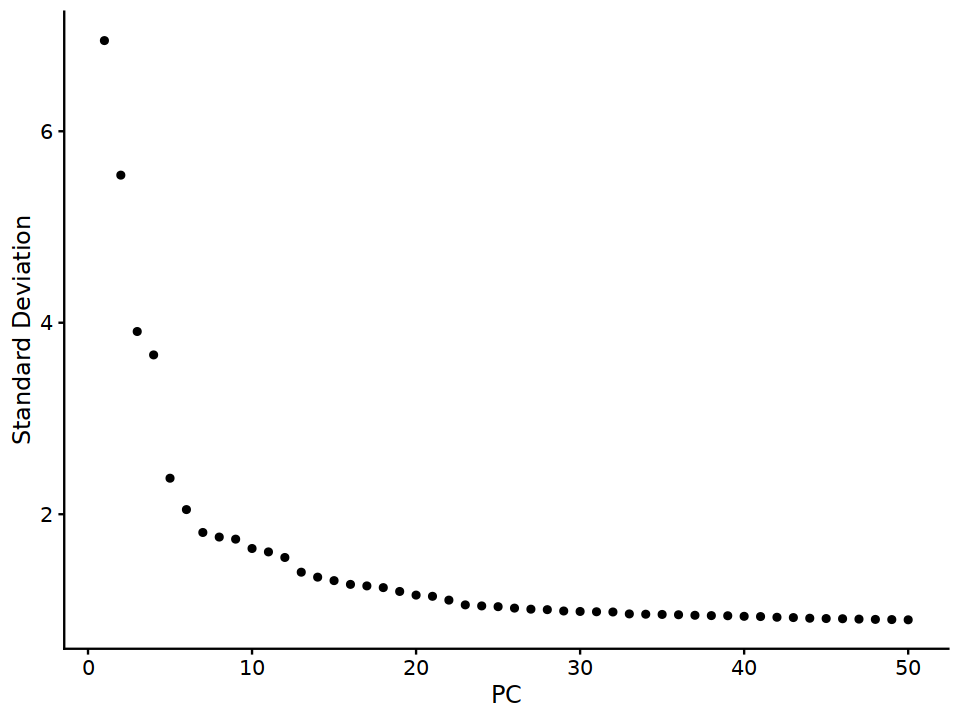

In [16]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

In [17]:
ProjectDim(seurat_obj, reduction = "pca")

PC_ 1 
Positive:  CD69, MALAT1, SKAP1, PCED1B-AS1, IFITM1, LTB, CD3E, IL32, CXCR4, CD247 
	   CD7, CD3D, BACH2, PRKCH, CAMK4, TCF7, IL7R, LEF1, BCL2, THEMIS 
Negative:  IFI30, LYZ, FCN1, S100A9, SERPINA1, TYROBP, FTL, LST1, AIF1, PLXDC2 
	   SPI1, CD68, CST3, S100A8, FCER1G, CTSS, PSAP, MNDA, PLAUR, NCF2 
PC_ 2 
Positive:  IL32, NKG7, GZMA, CD247, PRKCH, GAPDH, CCL5, CST7, PRF1, CD3E 
	   CD3D, SRGN, IFITM1, CTSW, CD7, S100A4, ANXA1, GZMB, TGFBR3, GZMH 
Negative:  BANK1, CD79A, MS4A1, RALGPS2, FCRL1, AFF3, NIBAN3, PAX5, EBF1, CD79B 
	   TCL1A, LINC00926, CD22, BLK, RUBCNL, HLA-DQA1, VPREB3, PLEKHG1, CD19, FCER2 
PC_ 3 
Positive:  HIST1H1B, RRM2, CD74, NKG7, HIST1H2AL, HIST1H3C, HIST1H3B, HIST1H2AH, HIST1H1E, HIST1H1C 
	   PRF1, CCL5, MKI67, STMN1, GZMB, CST7, GZMA, HMGB2, TUBA1B, HIST1H1D 
Negative:  IL7R, TCF7, LEF1, BCL2, LTB, FAM13A, MAL, NELL2, ANK3, CAMK4 
	   PCED1B-AS1, CD7, CD3E, JUNB, IFITM1, JUN, MALAT1, FOS, CD3D, AL589693.1 
PC_ 4 
Positive:  KLRD1, KLRF1, GNLY, ADGRG1, SH2

An object of class Seurat 
29656 features across 30389 samples within 1 assay 
Active assay: RNA (29656 features, 0 variable features)
 1 dimensional reduction calculated: pca

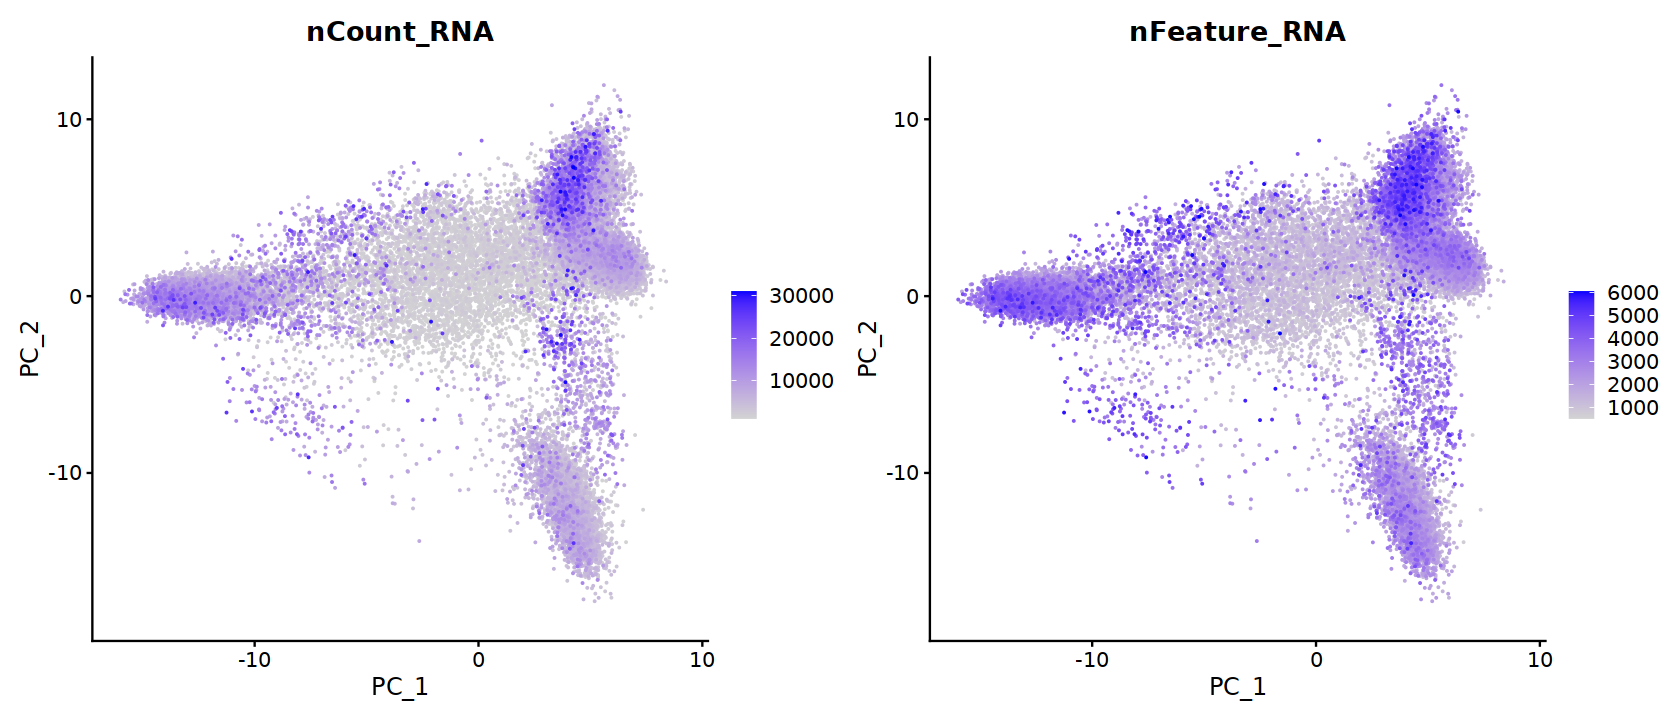

In [18]:
options(repr.plot.width = 14, repr.plot.height = 6)
FeaturePlot(object = seurat_obj, reduction = "pca",
        features = c("nCount_RNA","nFeature_RNA"), order=T)

## UMAP representation

In [19]:
comp=15

In [20]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:14:59 UMAP embedding parameters a = 0.9922 b = 1.112

14:14:59 Read 30389 rows and found 15 numeric columns

14:14:59 Using Annoy for neighbor search, n_neighbors = 30

14:14:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:15:03 Writing NN index file to temp file /scratch_tmp/33937378/RtmpQGmxV3/file338491027bd0c

14:15:03 Searching Annoy index using 1 thread, search_k = 3000

14:15:15 Annoy recall = 100%

14:15:15 Commencing smooth kNN distance calibration using 1 thread
 with t

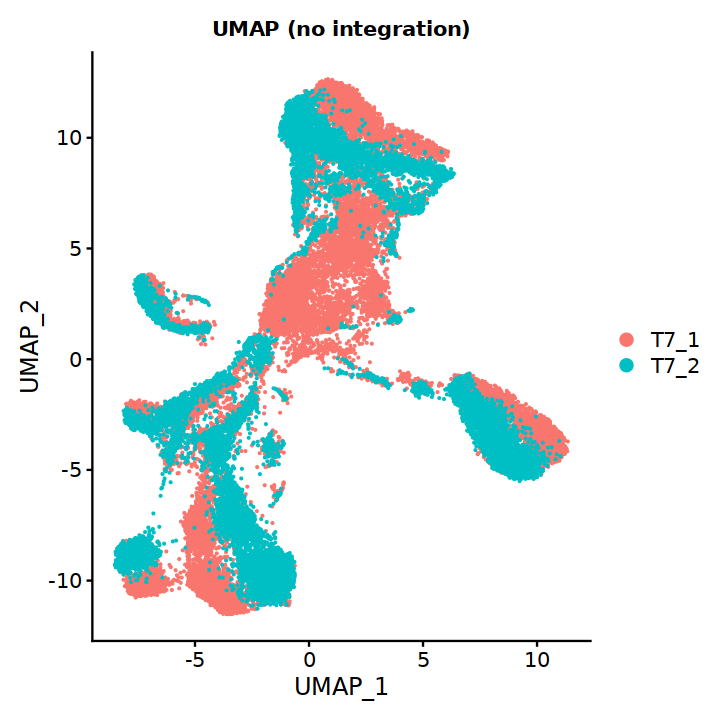

In [21]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP (no integration)') + 
     theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

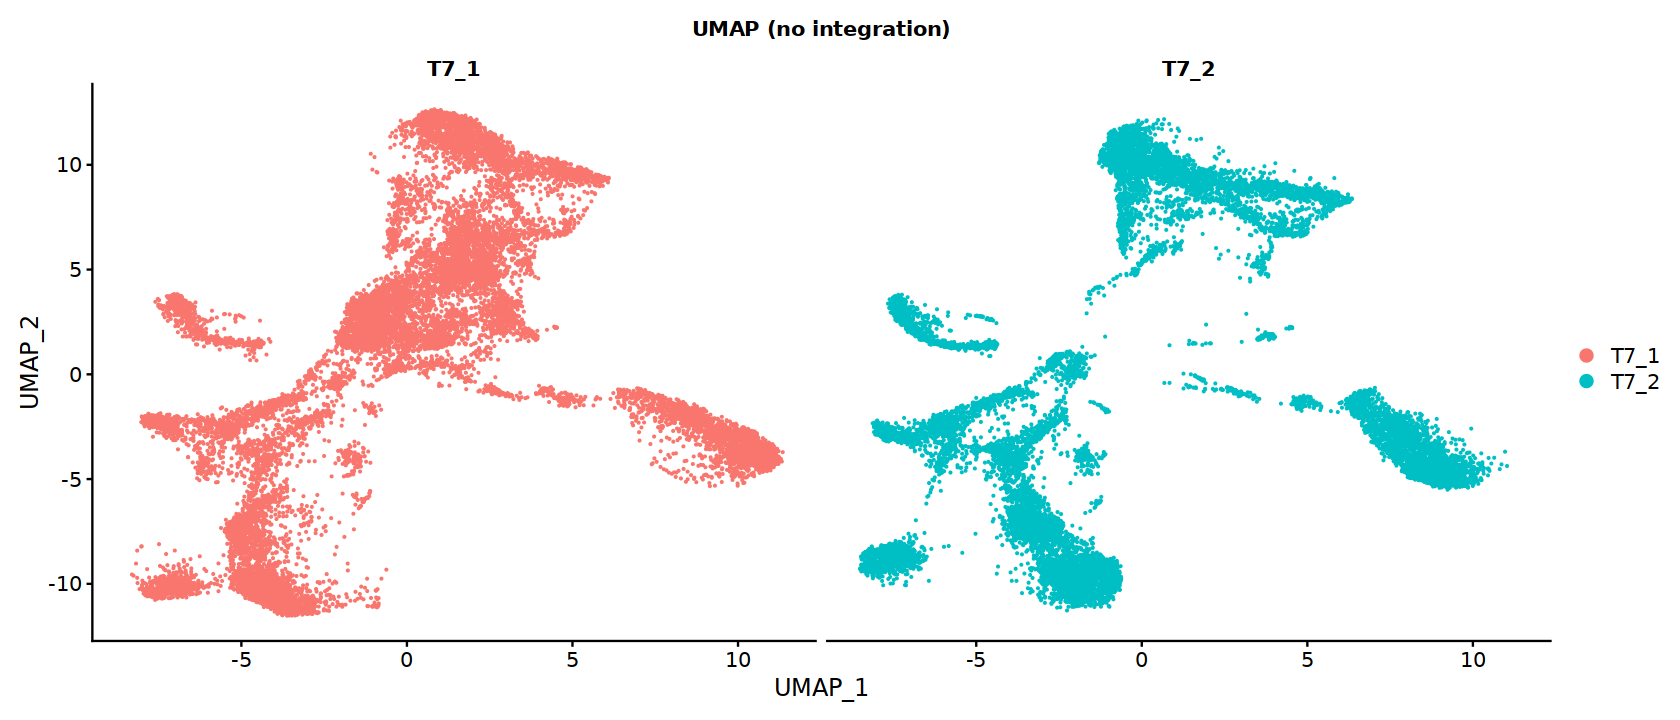

In [22]:
options(repr.plot.width = 14, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  split.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP (no integration)') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

## Integration with Harmony

In [23]:
# make a copy of the PCA reduction
seurat_obj@reductions$pca_filt <- seurat_obj@reductions$pca

# Filter to the desired number of components according to elbow
seurat_obj@reductions$pca_filt@cell.embeddings <- seurat_obj@reductions$pca_filt@cell.embeddings[, c(1:comp)]
seurat_obj@reductions$pca_filt@feature.loadings <- seurat_obj@reductions$pca_filt@feature.loadings[, c(1:comp)]

In [24]:
seurat_obj <- RunHarmony(
  object = seurat_obj,
  reduction = "pca_filt",
  group.by.vars = "sample_id",
  assay.use = "RNA",
  project.dim = FALSE,
  reduction.save = "harmony"
)

Transposing data matrix

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony converged after 5 iterations



In [25]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "harmony",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

14:16:25 UMAP embedding parameters a = 0.9922 b = 1.112

14:16:25 Read 30389 rows and found 15 numeric columns

14:16:25 Using Annoy for neighbor search, n_neighbors = 30

14:16:25 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:16:28 Writing NN index file to temp file /scratch_tmp/33937378/RtmpQGmxV3/file33849366095c9

14:16:28 Searching Annoy index using 1 thread, search_k = 3000

14:16:40 Annoy recall = 100%

14:16:41 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:16:43 Initializing from normalized Laplacian + noise (using irlba)

14:16:44 Commencing optimization for 200 epochs, with 1326658 positive edges

14:17:17 Optimization finished



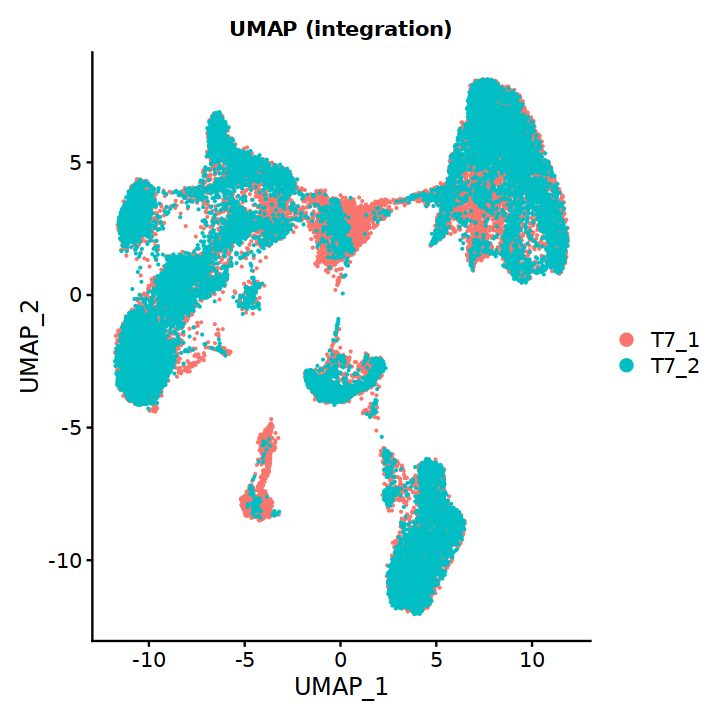

In [26]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP (integration)') + 
     theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

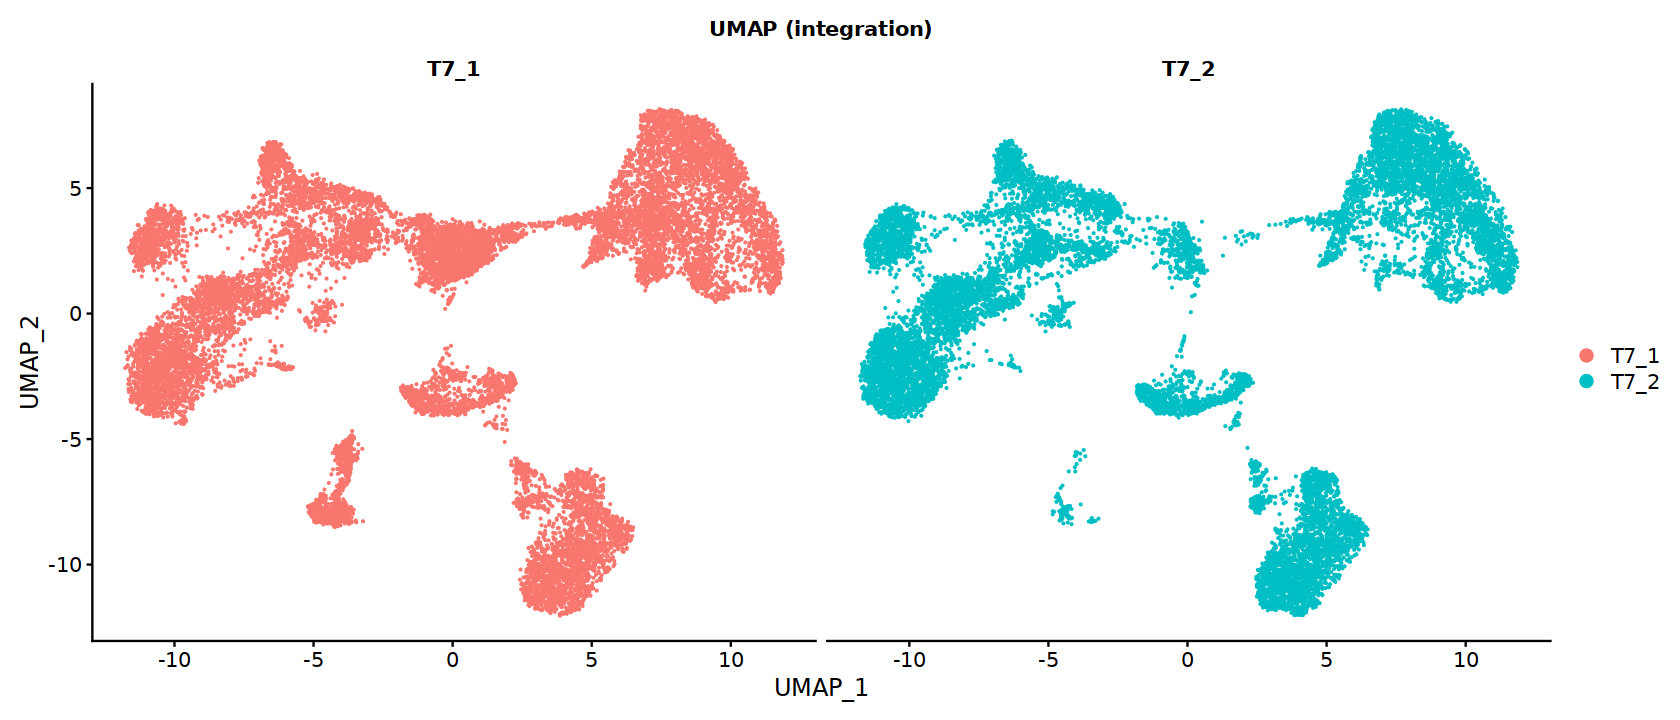

In [27]:
options(repr.plot.width = 14, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  split.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP (integration)') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

## More quality checks on UMAPs

### Compute Cell-Cycle Scores

In [28]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
seurat_obj <- CellCycleScoring(seurat_obj, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

### Plot several features

In [29]:
cat_vars <-c("Phase")
con_vars <- c("nCount_RNA", "nFeature_RNA", "pct_mt", "percent.ribo", 
              "doublet_score", "PTPRC", "HBM")
vars <- c(cat_vars, con_vars)

In [30]:
# compute plots
list_plots <- lapply(vars, function(var){
  if (var %in% cat_vars) {
      p <- DimPlot(seurat_obj, reduction = "umap", group.by=var)
  } else {
      p <- FeaturePlot(seurat_obj, reduction = "umap", feature=var, order = TRUE)
  }
  return(p)
})

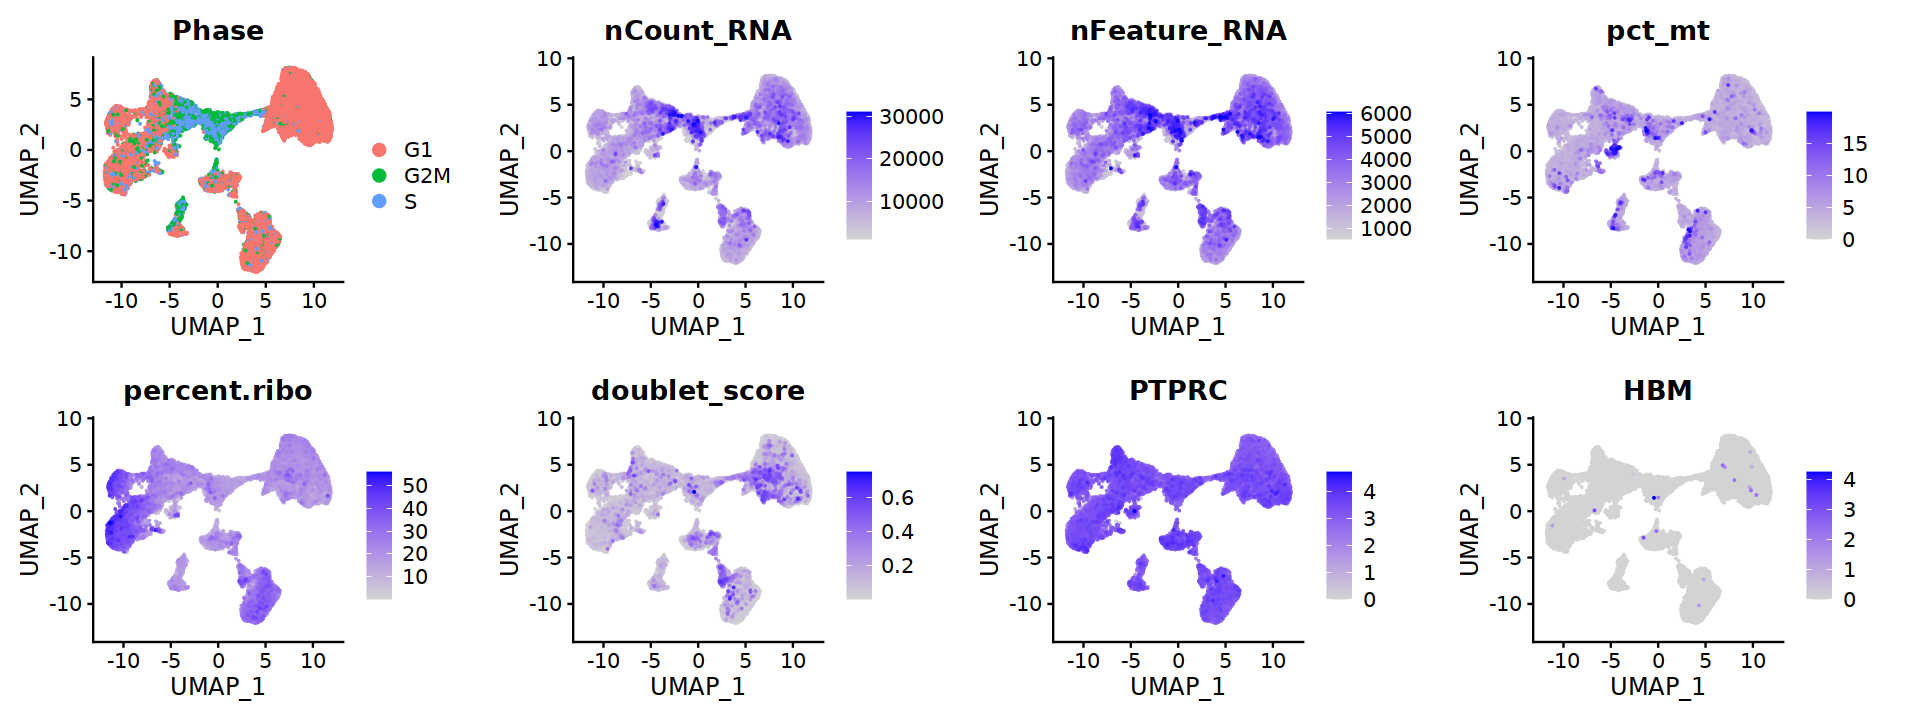

In [31]:
options(repr.plot.width = 16, repr.plot.height = 6, warn=-1,verbose = FALSE)
# show plots
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol = 4,
                   nrow = 2)
cp

# Save

In [32]:
saveRDS(seurat_obj, here::here(glue::glue("{clust}/{robj_dir}/dimred_combined_object_{timepoint}.rds")))

# Session Info

In [33]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scran_1.22.1                scater_1.22.0              
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_